# Exploratory Data Analysis

## Hardcoded Variables

In [1]:
weathercan_path = "C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/TM_PHES/weathercan_data.csv"
gauge_location_path = "C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/TM_PHES/gauge_data.csv"
elk_path = "C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/Elk River -Fernie.csv"
hosmer_path = "C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/Hosmer Creek - Diversions.csv"
michel_path = "C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/Michel Creek -Corbin Creek.csv"
crowsnest_path = "C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/Crowsnest River - Frank.csv"

## Import Libraries

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.stats import linregress
from itertools import combinations


## Utility Functions

In [3]:
def describe_dataframes_to_dataframe(dataframes_dict):
    """
    Takes a dictionary of DataFrames and creates a new DataFrame with the summary statistics
    from the .describe() method for each DataFrame.

    Parameters:
    - dataframes_dict: Dictionary where keys are DataFrame names and values are DataFrames.

    Returns:
    - summary_df: DataFrame containing summary statistics for each input DataFrame.
    """
    summary_data = {}
    
    for df_name, df in dataframes_dict.items():
        summary_data[df_name] = df.describe()
    
    summary_df = pd.concat(summary_data, axis=1).T
    return summary_df

In [4]:
def preprocess_weather_data(df):
    """
    Takes the weather canada data, drops unwanted columns and adds two new columns:
    'monthly_mean_precip': Averages the precipitation data over the month for each weather station
    'swe': Snow water equivalent calculated by SWE[cm] = snow density(-) * snow depth(cm)
           Snow density is assumed to be 0.1
    
    Parameters:
    - df: Weather Canada DataFrame

    Returns:
    - df: Weather Canada DataFrame with new columns and dropped columns
    """
    # Columns to drop
    columns_to_drop = ['station_operator', 'climate_id', 'WMO_id', 'TC_id']

    # Drop specified columns and columns containing the word 'flag'
    df.drop(columns=columns_to_drop + [col for col in df.columns if 'flag' in col.lower()], inplace=True)

    # Snow Density (assumed)
    snow_density = 0.1  # g/cm^3

    # Creating a new column for Snow Water Equivalent (SWE)
    df['swe'] = df['total_snow'] * snow_density

    # Creating a new column for mean monthly precip
    df['monthly_mean_precip'] = df.groupby(['station_name', 'year', 'month'])['total_precip'].transform('mean')
    
    return df

In [5]:

def create_new_dataframe(gauge_df):
    """
    Takes a gauge station dataframe, drops unwanted columns and adds two new columns:
    'Daily_Discharge_m3/s': Daily discharge value where PARAM = 1
    'Daily_Level_m': Daily water level where PARAM = 2
    
    Parameters:
    - gauge_df: Gauges Station DataFrame from original_dfs list in create_and_concat_dataframes()

    Returns:
    - new_df: gauge_df DataFrame with new columns and dropped columns
    """
    # Remove spaces from column names
    gauge_df.columns = gauge_df.columns.str.replace(' ', '')

    id_column_name = 'ID'

    # Create a mask for PARAM equal to 1
    param_1_mask = (gauge_df['PARAM'] == 1) & gauge_df['Value'].notna()

    # Create a mask for PARAM equal to 2
    param_2_mask = (gauge_df['PARAM'] == 2) & gauge_df['Value'].notna()

    # Create the new DataFrame using vectorized operations
    new_df = pd.DataFrame({
        'ID': gauge_df[id_column_name],
        'Date': gauge_df['Date'],
        'Value': gauge_df['Value'],
        'Daily_Discharge_m3/s': gauge_df['Value'].where(param_1_mask),
        'Daily_Level_m': gauge_df['Value'].where(param_2_mask)
    }).dropna(subset=['Value'])

    return new_df

In [6]:
def create_and_concat_dataframes(original_dfs, additional_df=None):
    """
    Takes the four gauge station data and uses the create_new_dataframe function to clean up. 
    Concatenates the dataframes and merges on with gauge station name and locations. 
    Calculates the Maximum Annual Discharge for each station.
    Parameters:
    - original_dfs: list of the gauge station DataFrames
    - additional_df: gauge station name and location DataFrame

    Returns:
    - concatenated_df: All interested gauge station data in one DataFrame
    """
    # Container for processed DataFrames
    processed_dfs = []

    for original_df in original_dfs:
        # Process each DataFrame using the create_new_dataframe function
        processed_df = create_new_dataframe(original_df)
        processed_dfs.append(processed_df)

    # Concatenate all processed DataFrames
    concatenated_df = pd.concat(processed_dfs, ignore_index=True)

    # If additional_df is provided, merge it with the concatenated_df
    if additional_df is not None:
        # Merge DataFrames on 'ID' column using 'outer' to keep all data from both DataFrames
        concatenated_df = pd.merge(concatenated_df, additional_df, on='ID', how='outer')
    
    # Convert 'Date' column to datetime
    concatenated_df['Date'] = concatenated_df['Date'].str.replace('/', '-')
    concatenated_df['Date'] = pd.to_datetime(concatenated_df['Date'])

    # Calculating max annual discharge
    # Extract the year from the 'Date' column and group by 'Station_name' and year, then calculate the maximum peak annual discharge
    concatenated_df['Year'] = concatenated_df['Date'].dt.year
    concatenated_df['Month'] = concatenated_df['Date'].dt.month
    max_peak_annual_discharge = concatenated_df.groupby(['Station_name', 'Year'])['Daily_Discharge_m3/s'].max().reset_index()

    # Rename the columns for clarity
    max_peak_annual_discharge.columns = ['Station_name', 'Year', 'Max_Peak_Annual_Discharge_m3/s']

    # Merge the max peak annual discharge back into the original DataFrame
    concatenated_df = pd.merge(concatenated_df, max_peak_annual_discharge, on=['Station_name', 'Year'], how='left')


    return concatenated_df

## Data Engineering

### Weather

elev(m) \
temp(°C) \
precip(cm)

In [7]:
weathercan_df = pd.read_csv(weathercan_path)
weathercan_df = preprocess_weather_data(weathercan_df)
weathercan_df.head(1)

C:\Users\14037\AppData\Local\Temp\ipykernel_35888\3508997774.py:1: DtypeWarning: Columns (7,9,14,16,18,20,22,24,26,28,30,32,34,36) have mixed types. Specify dtype option on import or set low_memory=False.
  weathercan_df = pd.read_csv(weathercan_path)


,station_name,station_id,prov,lat,lon,elev,date,year,month,day,...,max_temp,mean_temp,min_temp,snow_grnd,spd_max_gust,total_precip,total_rain,total_snow,swe,monthly_mean_precip
0,CROWSNEST CREEK,10690,AB,49.61,-114.68,1387.0,1998-01-01,1998,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Group by 'station_name'
grouped_df = weathercan_df.groupby('station_name')

# Create a dictionary to store DataFrames
station_dfs = {}

# Iterate through groups and create DataFrames
for station_name, station_group in grouped_df:
    # Name each DataFrame based on station_name
    df_name = station_name.replace(' ', '_') + '_df'
    # Add the DataFrame to the dictionary
    station_dfs[df_name] = station_group.copy()

# Get the list of all new station DataFrame names
new_station_df_names = list(station_dfs.keys())
new_station_df_names

['BLAIRMORE_HQTS_RS_df',
 'COLEMAN_df',
 'COLEMAN_RS_df',
 'CORBIN_df',
 'CROWSNEST_df',
 'CROWSNEST_CREEK_df',
 'IRONSTONE_LO_df',
 'NATAL_df',
 'NATAL_HARMER_RIDGE_df',
 'NATAL_KAISER_RESOURCES_df',
 'PELLETIER_CREEK_df',
 'SPARWOOD_df',
 'SPARWOOD_CS_df',
 'WILLOUGHBY_RIDGE_df']

In [29]:
weathercan_df.head(1)

,station_name,station_id,prov,lat,lon,elev,date,year,month,day,qual,cool_deg_days,dir_max_gust,heat_deg_days,max_temp,mean_temp,min_temp,snow_grnd,spd_max_gust,total_precip,total_rain,total_snow,swe,monthly_mean_precip
0,CROWSNEST CREEK,10690,AB,49.61,-114.68,1387.0,1998-01-01,1998,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

summary_df = describe_dataframes_to_dataframe(station_dfs)
summary_df

count          mean  \
BLAIRMORE_HQTS_RS_df      station_id           19367.0   2367.000000   
                          lat                  19367.0     49.620000   
                          lon                  19367.0   -114.430000   
                          elev                 19367.0   1310.600000   
                          year                 19367.0   1997.011876   
                          month                19367.0      6.520421   
                          day                  19367.0     15.724480   
                          cool_deg_days         7066.0      0.041509   
                          dir_max_gust             0.0           NaN   
                          heat_deg_days         7066.0     13.303043   
                          max_temp              7096.0     11.430651   
                          mean_temp             7066.0      4.738466   
                          min_temp              7141.0     -1.945960   
                          snow_grnd             3333.0      0.800780   
                          spd_max_gust             0.0           NaN   
                          total_precip          7204.0      1.739714   
                          total_rain            7203.0      1.194308   
                          total_snow            7205.0      0.613158   
                          swe                   7205.0      0.061316   
                          monthly_mean_precip   7319.0      1.775634   
COLEMAN_df                station_id           40643.0   2381.000000   
                          lat                  40643.0     49.630000   
                          lon                  40643.0   -114.580000   
                          elev                 40643.0   1341.100000   
                          year                 40643.0   1967.885638   
                          month                40643.0      6.531924   
                          day                  40643.0     15.727259   
                          cool_deg_days        11901.0      0.037778   
                          dir_max_gust             0.0           NaN   
                          heat_deg_days        11901.0     14.503025   
                          max_temp             11939.0      9.476556   
                          mean_temp            11901.0      3.534753   
                          min_temp             11910.0     -2.402242   
                          snow_grnd             3253.0      0.032278   
                          spd_max_gust             0.0           NaN   
                          total_precip         29964.0      1.503494   
                          total_rain           29965.0      0.930415   
                          total_snow           29965.0      0.572992   
                          swe                  29965.0      0.057299   
                          monthly_mean_precip  30044.0      1.515838   
COLEMAN_RS_df             station_id           24115.0   2382.000000   
                          lat                  24115.0     49.650000   
                          lon                  24115.0   -114.500000   
                          elev                 24115.0   1341.100000   
                          year                 24115.0   1990.512171   
                          month                24115.0      6.520962   
                          day                  24115.0     15.725358   
                          cool_deg_days         2236.0      0.077281   
                          dir_max_gust             0.0           NaN   
                          heat_deg_days         2236.0     11.501699   
                          max_temp              2355.0     13.278726   
                          mean_temp             2236.0      6.575581   
                          min_temp              2259.0     -0.085436   
                          snow_grnd                0.0           NaN   
                          spd_max_gust             0.0           NaN   
                 

In [10]:
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')

### Hydrometric

Daily Discharge (m&sup3;/s)\
Daily Water Level (m)

In [11]:
gauge_location_df = pd.read_csv(gauge_location_path)
elk_df = pd.read_csv(elk_path, header=1)
hosmer_df = pd.read_csv(hosmer_path, header=1)
michel_df = pd.read_csv(michel_path, header=1)
crowsnest_df = pd.read_csv(crowsnest_path, header=1)

In [12]:
gauge_location_df.head(3)

,Station_name,ID,Years,lat,lon,gross_drainage_area_km2,lat_dd,lon_dd
0,ELK RIVER AT FERNIE,08NK002,1925-2022,"49°30'12"" N","115°04'12"" W",3090.0,49.503333,-115.070000
1,HOSMER CREEK ABOVE DIVERSIONS,08NK026,1981-2021,"49°35'06"" N","114°57'24"" W",6.4,49.585000,-114.956667
2,MICHEL CREEK ABOVE CORBIN CREEK,08NK028,1984-1995,"49°30'44"" N","114°40'33"" W",35.9,49.512222,-114.675833


In [13]:
elk_df.head(2)

,ID,PARAM,Date,Value,SYM
0,08NK002,1,1925/05/22,205.0,NaN
1,08NK002,1,1925/05/23,200.0,NaN


In [14]:
filtered_rows1 = crowsnest_df.query("PARAM == 2")
filtered_rows1.count()

 ID      4018
PARAM    4018
Date     4018
Value    3978
SYM        13
dtype: int64

In [15]:
original_dfs = [elk_df, hosmer_df, michel_df, crowsnest_df]

# Call the function to create, concatenate, and merge DataFrames
hydrometric_df = create_and_concat_dataframes(original_dfs, gauge_location_df)
hydrometric_df.head(3)

,ID,Date,Value,Daily_Discharge_m3/s,Daily_Level_m,Station_name,Years,lat,lon,gross_drainage_area_km2,lat_dd,lon_dd,Year,Month,Max_Peak_Annual_Discharge_m3/s
0,08NK002,1925-05-22,205.0,205.0,NaN,ELK RIVER AT FERNIE,1925-2022,"49°30'12"" N","115°04'12"" W",3090.0,49.503333,-115.07,1925,5,205.0
1,08NK002,1925-05-23,200.0,200.0,NaN,ELK RIVER AT FERNIE,1925-2022,"49°30'12"" N","115°04'12"" W",3090.0,49.503333,-115.07,1925,5,205.0
2,08NK002,1925-05-24,192.0,192.0,NaN,ELK RIVER AT FERNIE,1925-2022,"49°30'12"" N","115°04'12"" W",3090.0,49.503333,-115.07,1925,5,205.0


In [16]:
hydrometric_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77310 entries, 0 to 77309
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   ID                              77310 non-null  object        
 1   Date                            77310 non-null  datetime64[ns]
 2   Value                           77310 non-null  float64       
 3   Daily_Discharge_m3/s            65541 non-null  float64       
 4   Daily_Level_m                   11769 non-null  float64       
 5   Station_name                    77310 non-null  object        
 6   Years                           77310 non-null  object        
 7   lat                             77310 non-null  object        
 8   lon                             77310 non-null  object        
 9   gross_drainage_area_km2         77310 non-null  float64       
 10  lat_dd                          77310 non-null  float64       
 11  lo

## Plots & Analysis

### Weather Station Visuals

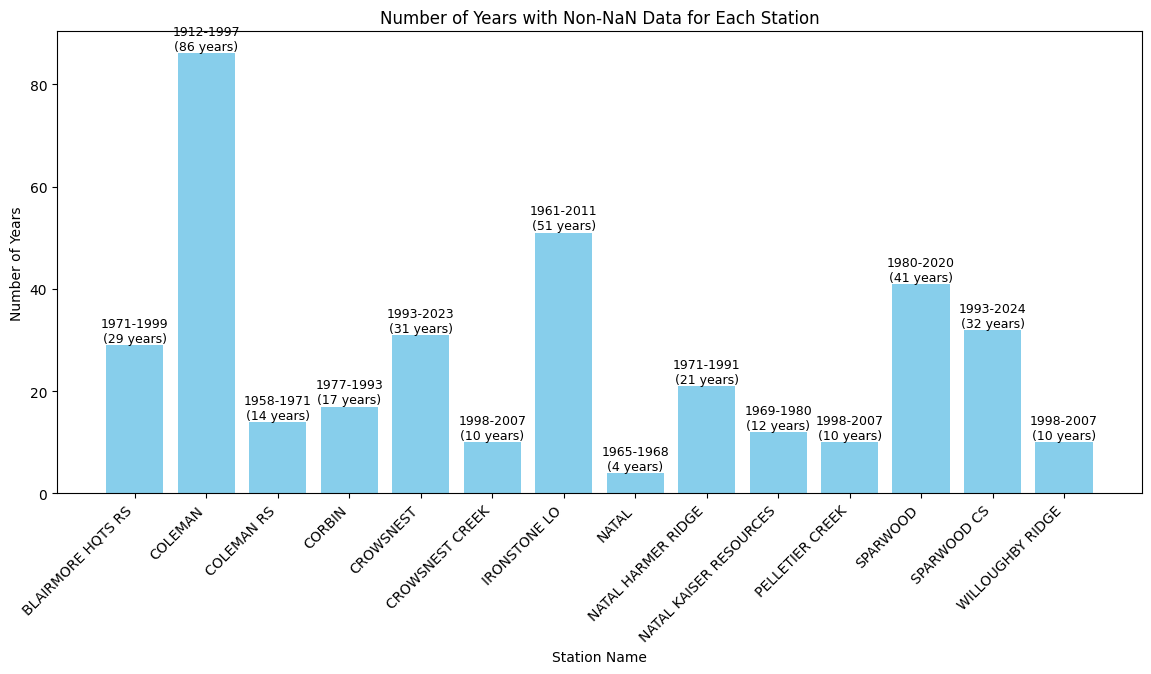

In [17]:
# Group by 'station_name' and get the range of years for each station
station_years_range = (
    weathercan_df.dropna(subset=['total_precip'])  # Exclude rows with NaN in 'total_precip'
    .groupby('station_name')['year']
    .agg(['min', 'max'])
)

# Calculate the number of years for each station
station_years_range['count'] = station_years_range['max'] - station_years_range['min'] + 1

# Plotting the histogram with the correct year range and station names
plt.figure(figsize=(14, 6))

# Plotting the bar chart
bar_plot = plt.bar(station_years_range.index, station_years_range['count'], color='skyblue')

# Adding text on top of each bar with the correct year range
for bar, min_year, max_year, count in zip(bar_plot, station_years_range['min'], station_years_range['max'], station_years_range['count']):
    end_year = min(max_year, weathercan_df['year'].max())  # Set the maximum year to the overall max year
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{min_year}-{end_year}\n({count} years)",
             ha='center', va='bottom', fontsize=9, color='black')

plt.title('Number of Years with Non-NaN Data for Each Station')
plt.xlabel('Station Name')
plt.ylabel('Number of Years')
plt.xticks(rotation=45, ha='right')
plt.show()

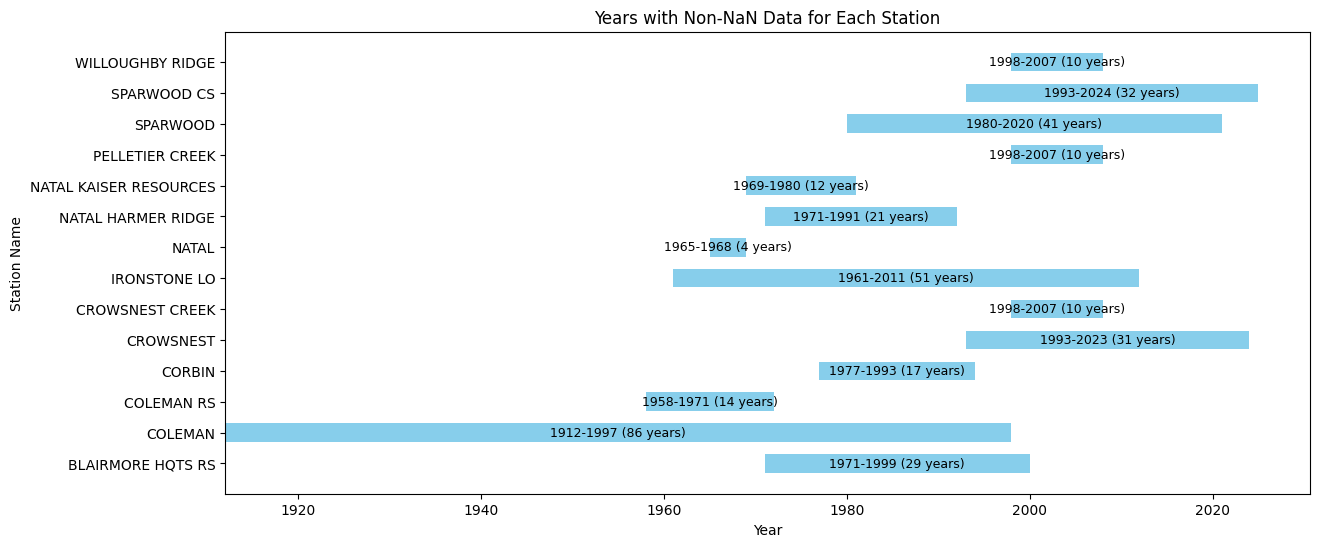

In [18]:

# Group by 'station_name' and get the range of years for each station
station_years_range = (
    weathercan_df.dropna(subset=['total_precip'])  # Exclude rows with NaN in 'total_precip'
    .groupby('station_name')['year']
    .agg(['min', 'max'])
)

# Calculate the number of years for each station
station_years_range['count'] = station_years_range['max'] - station_years_range['min'] + 1

# Plotting the horizontal bar chart
plt.figure(figsize=(14, 6))
bar_plot = plt.barh(station_years_range.index, station_years_range['count'], 
                   left=station_years_range['min'], color='skyblue', height=0.6)

# Adding concise text beside each bar with the correct year range
for bar, min_year, max_year, count in zip(bar_plot, station_years_range['min'], station_years_range['max'], station_years_range['count']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2,
             f"{min_year}-{max_year} ({count} years)", ha='center', va='center', fontsize=9, color='black')

plt.title('Years with Non-NaN Data for Each Station')
plt.xlabel('Year')
plt.ylabel('Station Name')
plt.show()


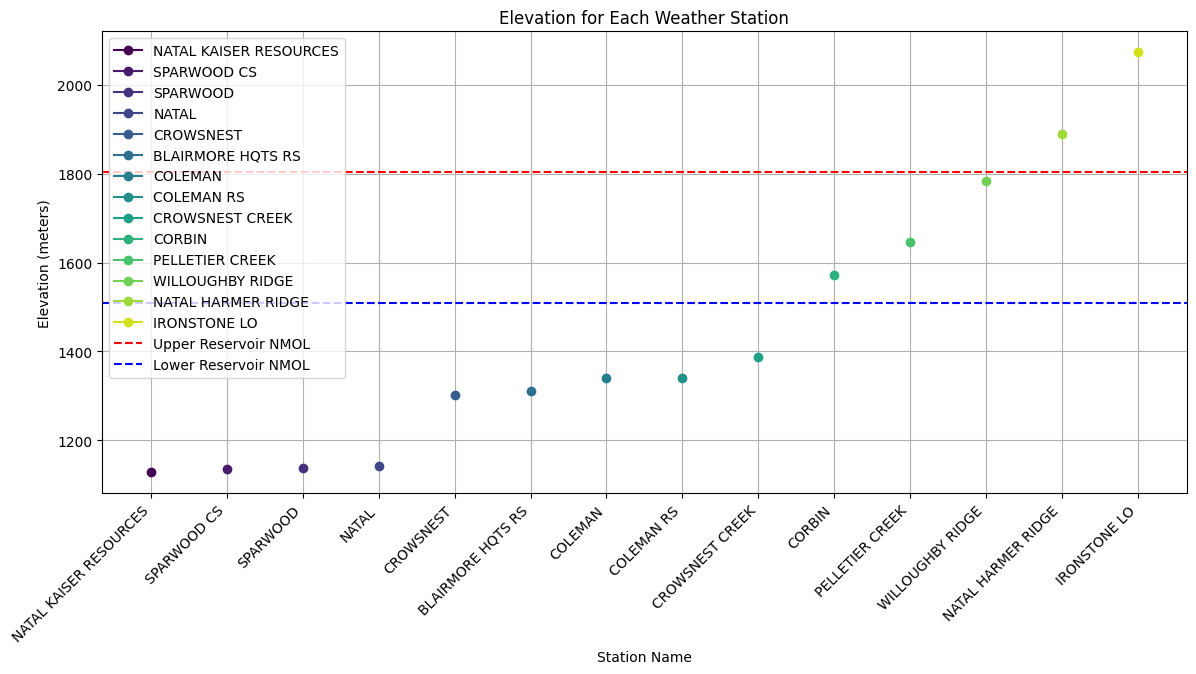

In [19]:
# Group by 'station_name' and get the mean elevation for each station
station_elevation = weathercan_df.groupby('station_name')['elev'].mean().reset_index()

# Sorting the data by elevation for better visualization
station_elevation = station_elevation.sort_values(by='elev')

# Elevation values for Upper and Lower Reservoir NMOL
upper_reservoir_elevation = 1803.3
lower_reservoir_elevation = 1509

# Plotting the line chart for station elevations with labels and different colors
plt.figure(figsize=(14, 6))
for i, (station, elevation) in enumerate(zip(station_elevation['station_name'], station_elevation['elev'])):
    plt.plot([i], [elevation], marker='o', linestyle='-', label=station, color=plt.cm.viridis(i / len(station_elevation)))

# Adding horizontal lines for Upper and Lower Reservoir NMOL elevations
plt.axhline(y=upper_reservoir_elevation, color='red', linestyle='--', label='Upper Reservoir NMOL')
plt.axhline(y=lower_reservoir_elevation, color='blue', linestyle='--', label='Lower Reservoir NMOL')

plt.title('Elevation for Each Weather Station')
plt.xlabel('Station Name')
plt.ylabel('Elevation (meters)')
plt.xticks(range(len(station_elevation)), station_elevation['station_name'], rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.show()

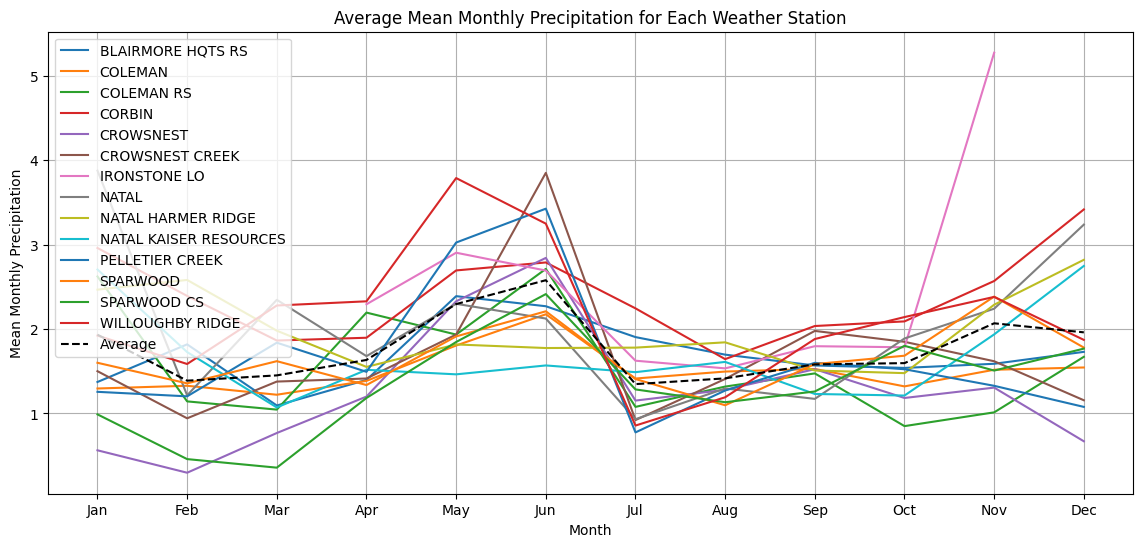

In [20]:
# Group by 'station_name', 'year', and 'month' and calculate the mean precipitation
mean_monthly_precip = (
    weathercan_df.groupby(['station_name', 'month'])['total_precip']
    .mean()
    .reset_index()
)

# Group by 'month' and calculate the average mean monthly precipitation for each station
average_monthly_precip = mean_monthly_precip.groupby('month')['total_precip'].mean().reset_index()

# Pivot the table to have each station as a line on the plot
station_monthly_precip = mean_monthly_precip.pivot(index='month', columns='station_name', values='total_precip')

# Plotting the line chart for average mean monthly precipitation for each station
plt.figure(figsize=(14, 6))
for station in station_monthly_precip.columns:
    plt.plot(station_monthly_precip.index, station_monthly_precip[station], label=station)

# Plotting the average mean monthly precipitation line
plt.plot(average_monthly_precip['month'], average_monthly_precip['total_precip'], linestyle='--', color='black', label='Average')

plt.title('Average Mean Monthly Precipitation for Each Weather Station')
plt.xlabel('Month')
plt.ylabel('Mean Monthly Precipitation')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid(True)
plt.show()

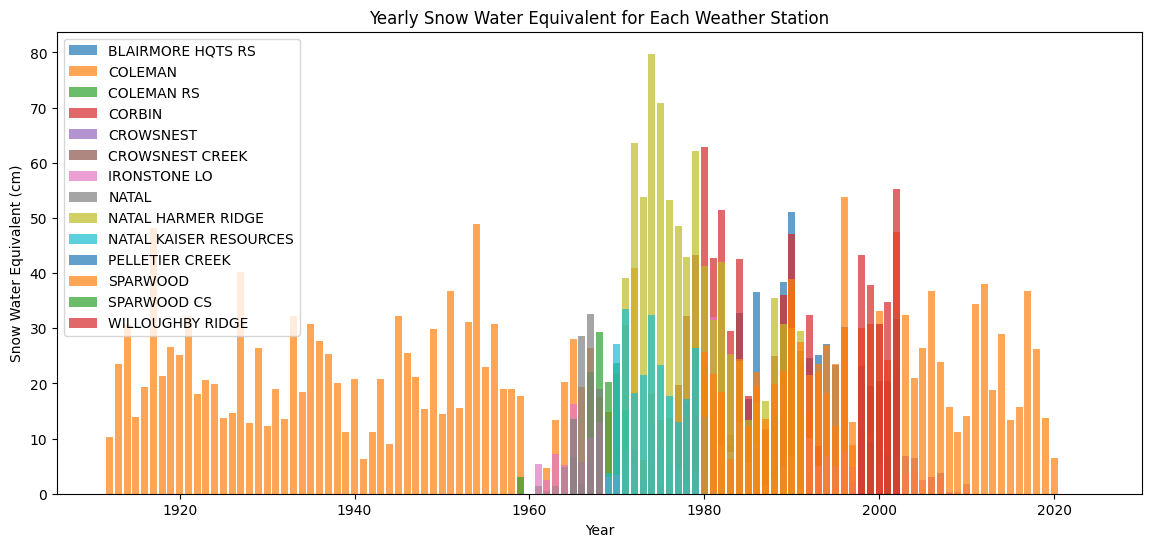

In [21]:
# Group by 'station_name' and 'year', then calculate the sum of snow water equivalent for each year and station
yearly_swe = weathercan_df.groupby(['station_name', 'year'])['swe'].sum().reset_index()

# Plotting the bar chart
plt.figure(figsize=(14, 6))
for station in yearly_swe['station_name'].unique():
    station_data = yearly_swe[yearly_swe['station_name'] == station]
    plt.bar(station_data['year'], station_data['swe'], label=station, alpha=0.7)

plt.title('Yearly Snow Water Equivalent for Each Weather Station')
plt.xlabel('Year')
plt.ylabel('Snow Water Equivalent (cm)')
plt.legend()
plt.show()

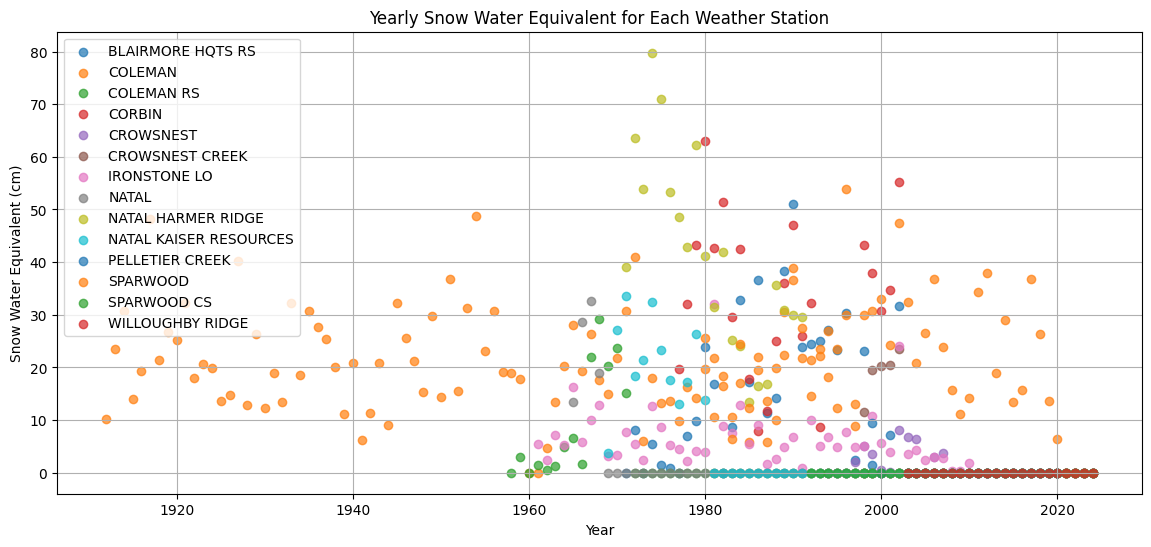

In [22]:
# Group by 'station_name' and 'year', then calculate the sum of snow water equivalent for each year and station
yearly_swe = weathercan_df.groupby(['station_name', 'year'])['swe'].sum().reset_index()

# Plotting the scatter plot
plt.figure(figsize=(14, 6))
for station in yearly_swe['station_name'].unique():
    station_data = yearly_swe[yearly_swe['station_name'] == station]
    plt.scatter(station_data['year'], station_data['swe'], label=station, alpha=0.7)

plt.title('Yearly Snow Water Equivalent for Each Weather Station')
plt.xlabel('Year')
plt.ylabel('Snow Water Equivalent (cm)')
plt.legend()
plt.grid(True)
plt.show()

### Gauge Station Visuals

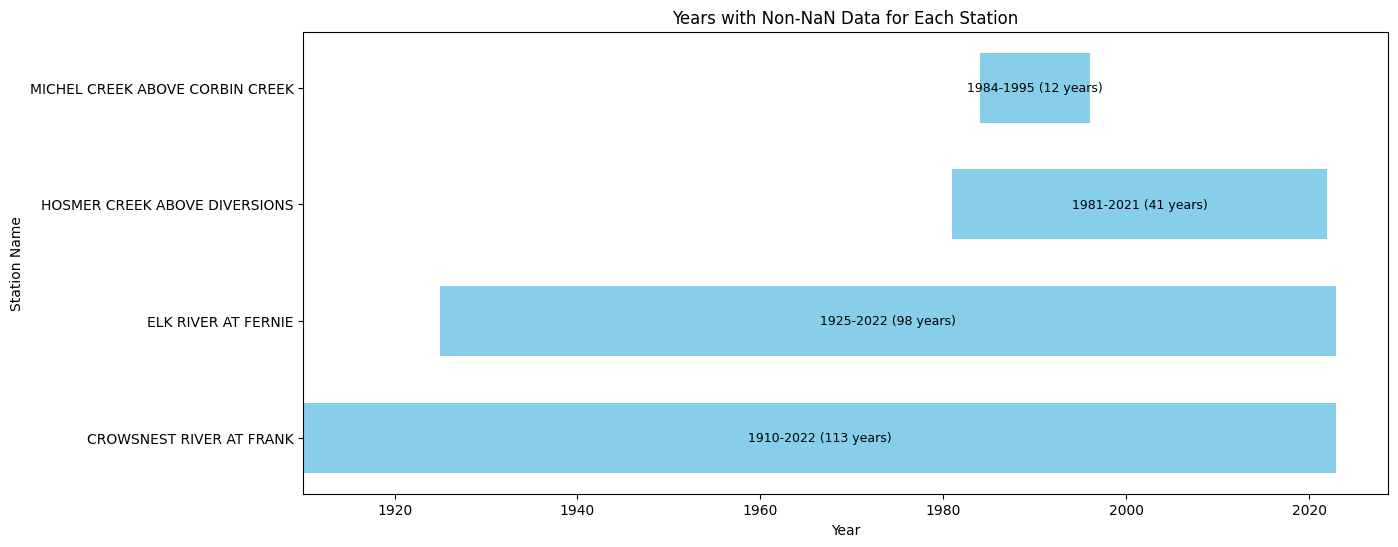

In [23]:
# Group by 'Station_name' and get the range of years for each station
station_years_range = (
    hydrometric_df.dropna(subset=['Date'])  # Exclude rows with NaN in 'Date'
    .groupby('Station_name')['Date']
    .agg(['min', 'max'])
)

# Calculate the number of years for each station
station_years_range['count'] = station_years_range['max'].dt.year - station_years_range['min'].dt.year + 1

# Plotting the horizontal bar chart
plt.figure(figsize=(14, 6))
bar_plot = plt.barh(station_years_range.index, station_years_range['count'], 
                   left=station_years_range['min'].dt.year, color='skyblue', height=0.6)

# Adding concise text beside each bar with the correct year range
for bar, min_year, max_year, count in zip(bar_plot, station_years_range['min'].dt.year, station_years_range['max'].dt.year, station_years_range['count']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2,
             f"{min_year}-{max_year} ({count} years)", ha='center', va='center', fontsize=9, color='black')

plt.title('Years with Non-NaN Data for Each Station')
plt.xlabel('Year')
plt.ylabel('Station Name')
plt.show()


In [24]:

# plot flows over time for each gauge (peak annual discharge vs drainage area)


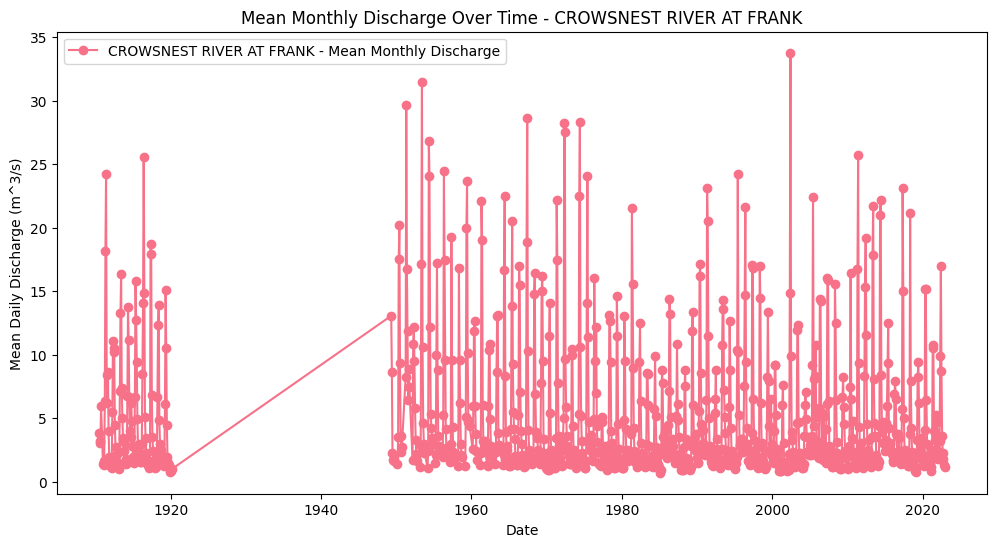

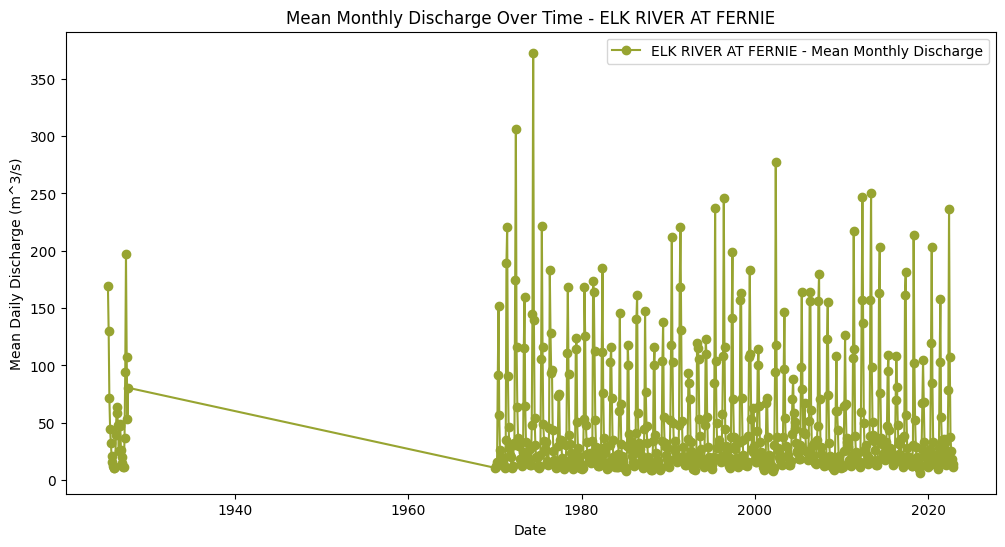

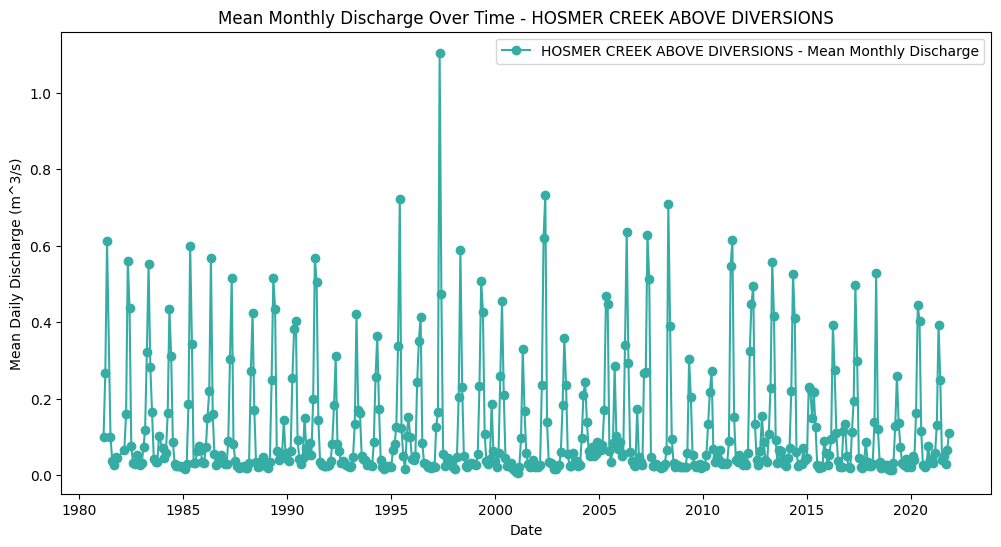

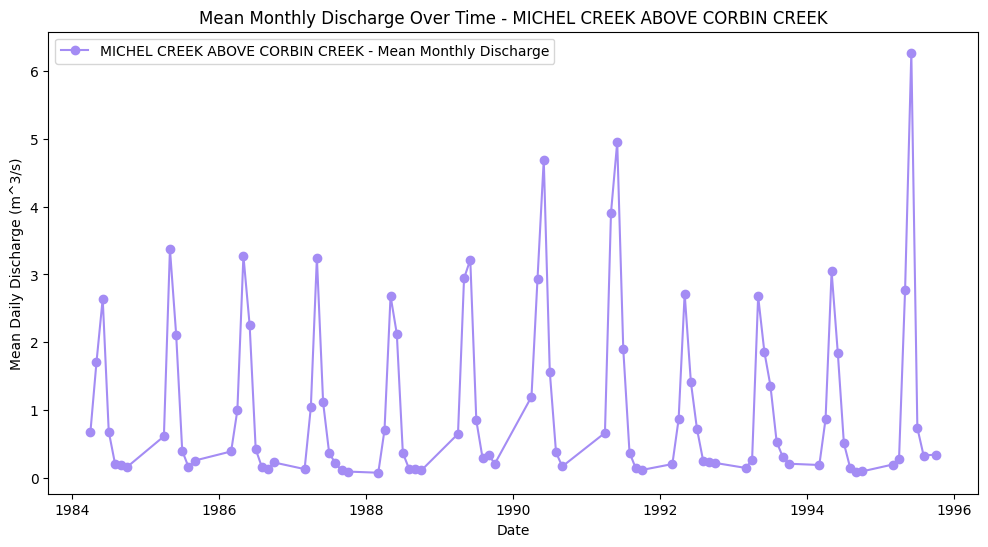

In [25]:
# Group by 'Station_name', 'Year', and 'Month', then calculate the mean monthly discharge
mean_monthly_discharge = hydrometric_df.groupby(['Station_name', 'Year', 'Month'])['Daily_Discharge_m3/s'].mean().reset_index()

# Create a new 'Date' column combining 'Year' and 'Month'
mean_monthly_discharge['Year_Month'] = pd.to_datetime(mean_monthly_discharge[['Year', 'Month']].assign(DAY=1))

# Create a color palette for each station
palette = sns.color_palette('husl', n_colors=len(mean_monthly_discharge['Station_name'].unique()))
station_color_dict = dict(zip(mean_monthly_discharge['Station_name'].unique(), palette))

# Loop through each station and create individual plots
stations = mean_monthly_discharge['Station_name'].unique()

for station in stations:
    station_data = mean_monthly_discharge[mean_monthly_discharge['Station_name'] == station]
    
    plt.figure(figsize=(12, 6))
    plt.plot(station_data['Year_Month'], station_data['Daily_Discharge_m3/s'], label=f'{station} - Mean Monthly Discharge', marker='o', color=station_color_dict[station])
    plt.title(f'Mean Monthly Discharge Over Time - {station}')
    plt.xlabel('Date')
    plt.ylabel('Mean Daily Discharge (m^3/s)')
    plt.legend()
    plt.show()

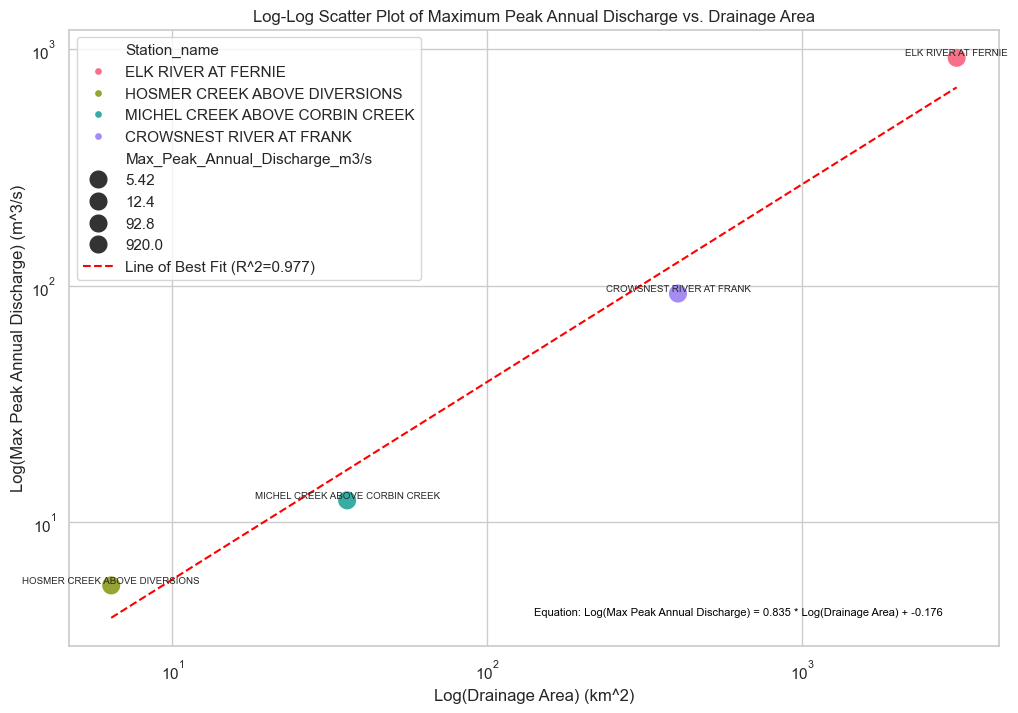

In [26]:
# Create a DataFrame with unique station information (including drainage area)
unique_station_info = hydrometric_df[['Station_name', 'gross_drainage_area_km2']].drop_duplicates()

# Merge unique station information with maximum peak annual discharge data
station_peak_area = pd.merge(unique_station_info, hydrometric_df.groupby('Station_name')['Max_Peak_Annual_Discharge_m3/s'].max().reset_index(), on='Station_name')

# Set up Seaborn style
sns.set(style="whitegrid")

# Plotting the log-log scatter plot
plt.figure(figsize=(12, 8))
scatter_plot = sns.scatterplot(
    x='gross_drainage_area_km2',
    y='Max_Peak_Annual_Discharge_m3/s',
    hue='Station_name',
    size='Max_Peak_Annual_Discharge_m3/s', 
    sizes=(200, 200),
    data=station_peak_area,
    palette=sns.color_palette("husl", n_colors=len(station_peak_area['Station_name'])),
    legend='full'
)
# Adding labels above the dots
for i, row in station_peak_area.iterrows():
    plt.text(row['gross_drainage_area_km2'], row['Max_Peak_Annual_Discharge_m3/s'], row['Station_name'],
             fontsize=7, ha='center', va='bottom')

# Adding labels and title
plt.title('Log-Log Scatter Plot of Maximum Peak Annual Discharge vs. Drainage Area')
plt.xlabel('Log(Drainage Area) (km^2)')
plt.ylabel('Log(Max Peak Annual Discharge) (m^3/s)')

# Setting log scale for both axes
plt.xscale('log')
plt.yscale('log')

# Adding a regression line
slope, intercept, r_value, p_value, std_err = linregress(np.log(station_peak_area['gross_drainage_area_km2']),
                                                          np.log(station_peak_area['Max_Peak_Annual_Discharge_m3/s']))

x_values = np.linspace(np.log(station_peak_area['gross_drainage_area_km2'].min()),
                       np.log(station_peak_area['gross_drainage_area_km2'].max()), 100)
y_values = slope * x_values + intercept

plt.plot(np.exp(x_values), np.exp(y_values), color='red', linestyle='--', label=f'Line of Best Fit (R^2={r_value**2:.3f})')

# Displaying the equation of the line
equation_label = f'Equation: Log(Max Peak Annual Discharge) = {slope:.3f} * Log(Drainage Area) + {intercept:.3f}'
plt.text(0.5, 0.05, equation_label, transform=scatter_plot.transAxes, fontsize=8, color='black')


# Displaying the legend
plt.legend()

# Displaying the plot
plt.show()

## Cross-Correlation 

In [154]:
selected_columns = ['station_name', 'station_id', 'date', 'total_precip']
weathercan_total_precip_df = weathercan_df[selected_columns].copy()

weathercan_total_precip_df.to_csv('weathercan_total_precip.csv', index=False)

In [ ]:
# find station combinations of at least 5 years if overlapping daily data

#station_name	station_id	prov	lat	lon	elev	date	year	month	day	qual	cool_deg_days	dir_max_gust	heat_deg_days	max_temp	mean_temp	min_temp	snow_grnd	spd_max_gust	total_precip	total_rain	total_snow	swe	monthly_mean_precip

### Station Combinations of at least 5 years of overlapping daily data

In [119]:

def transform_to_station_date_dataframe(input_df):
    # Pivot the DataFrame to get 'date' as index, 'station_name' as columns, and 'total_precip' as values
    result_df = input_df.dropna(subset=['total_precip']).replace(0, pd.NA)
    result_df = result_df.pivot(index='date', columns='station_name', values='total_precip')
    transformed_df = result_df.dropna(axis=1, how='all').dropna()

    # Set values to float
    column_list = [col for col in transformed_df.columns if col != 'date']
    transformed_df[column_list] = transformed_df[column_list].apply(pd.to_numeric, errors='coerce')

    # Reset the index to make 'date' a column again
    transformed_df.reset_index(inplace=True)

    return transformed_df


In [111]:
# def extract_and_transform(station_names, weathercan_df):
#     # Filter data for the specified station names
#     selected_data = weathercan_df[weathercan_df['station_name'].isin(station_names)]

#     # Find overlapping dates
#     overlapping_dates = selected_data.groupby('date')['station_name'].count().eq(len(station_names))
#     overlapping_dates = overlapping_dates[overlapping_dates].index

#     # Filter data for overlapping dates
#     overlapping_data = selected_data[selected_data['date'].isin(overlapping_dates)]

#     # Extract relevant columns
#     result_df = overlapping_data[['station_name', 'date', 'total_precip']] # , 'mean_temp'
#     # Drop NaN values within the 'total_precip' column
#     result_df = result_df.dropna(subset=['total_precip'])


#     transformed_df = transform_to_station_date_dataframe(result_df)

#     return transformed_df



In [138]:

def extract_and_transform(station_names, weathercan_df):
    # Check if 'station_name' column exists in the DataFrame
    if 'station_name' not in weathercan_df.columns:
        raise ValueError("No 'station_name' column found in the DataFrame.")

    # Filter DataFrame based on specified station names
    result_df = weathercan_df[weathercan_df['station_name'].isin(station_names)].copy()
    result_df = result_df[['station_name', 'date', 'total_precip']]
    transformed_df = transform_to_station_date_dataframe(result_df)

    return transformed_df



In [142]:
combo1 = ['IRONSTONE LO', 'COLEMAN RS', 'COLEMAN']
combo2 = ['NATAL KAISER RESOURCES', 'NATAL HARMER RIDGE', 'IRONSTONE LO', 'COLEMAN', 'BLAIRMORE HQTS RS']
combo3 = ['NATAL HARMER RIDGE', 'IRONSTONE LO', 'CROWSNEST', 'COLEMAN', 'BLAIRMORE HQTS RS']
combo4 = ['WILLOUGHBY RIDGE', 'SPARWOOD CS', 'SPARWOOD', 'PELLETIER CREEK', 'IRONSTONE LO', 'CROWSNEST CREEK', 'CROWSNEST']

combo5 = ['COLEMAN', 'BLAIRMORE HQTS RS']
combo6 = ['COLEMAN', 'IRONSTONE LO']
combo7 = ['IRONSTONE LO', 'CROWSNEST']
combo8 = ['IRONSTONE LO', 'NATAL HARMER RIDGE']
combo9 = ['SPARWOOD CS', 'SPARWOOD']
combo10 = ['WILLOUGHBY RIDGE', 'SPARWOOD']
combo11 = ['COLEMAN', 'IRONSTONE LO']
combo12 = ['NATAL HARMER RIDGE', 'NATAL KAISER RESOURCES']
combo13 = ['IRONSTONE LO', 'BLAIRMORE HQTS RS']

In [120]:
combo1_df = extract_and_transform(combo1, weathercan_df)
combo1_df.head()

station_name,date,COLEMAN,COLEMAN RS,IRONSTONE LO
0,1962-05-15,3.0,4.1,2.5
1,1962-05-18,10.9,15.0,12.7
2,1962-05-19,3.8,4.3,4.1
3,1962-06-02,1.0,1.0,1.0
4,1962-06-08,3.3,2.5,3.8


In [121]:
combo1_df.describe() # not enough data

station_name,date,COLEMAN,COLEMAN RS,IRONSTONE LO
count,287,287.000000,287.000000,287.000000
mean,1966-05-09 05:26:07.944250864,6.850871,6.659582,8.170035
min,1962-05-15 00:00:00,0.300000,0.300000,0.300000
25%,1964-07-14 00:00:00,2.300000,2.000000,2.650000
50%,1966-05-31 00:00:00,4.600000,4.100000,5.600000
75%,1968-06-22 12:00:00,9.100000,8.750000,10.200000
max,1970-09-08 00:00:00,52.300000,53.600000,58.400000
std,NaN,7.108716,7.376345,8.422186


In [122]:
nan_check = combo1_df.isna().any()
nan_check[nan_check].index.tolist()
combo1_df.isna().sum()

station_name
date            0
COLEMAN         0
COLEMAN RS      0
IRONSTONE LO    0
dtype: int64

In [123]:
combo2_df = extract_and_transform(combo2, weathercan_df)
combo2_df.head()

station_name,date,BLAIRMORE HQTS RS,COLEMAN,IRONSTONE LO,NATAL HARMER RIDGE,NATAL KAISER RESOURCES
0,1971-07-27,12.2,14.5,8.6,6.9,7.6
1,1972-06-09,2.5,20.3,7.6,7.1,10.9
2,1972-06-10,5.1,5.6,1.0,5.1,4.8
3,1972-06-12,3.0,1.5,0.5,2.0,0.3
4,1972-06-15,1.0,3.8,1.0,2.8,0.3


In [124]:
combo2_df.describe()

station_name,date,BLAIRMORE HQTS RS,COLEMAN,IRONSTONE LO,NATAL HARMER RIDGE,NATAL KAISER RESOURCES
count,142,142.000000,142.000000,142.000000,142.000000,142.00000
mean,1976-04-02 08:27:02.535211264,8.659859,8.700704,9.715493,7.926761,7.20000
min,1971-07-27 00:00:00,0.200000,0.300000,0.200000,0.300000,0.30000
25%,1975-06-07 06:00:00,2.100000,3.000000,2.825000,3.000000,2.85000
50%,1976-07-12 12:00:00,5.300000,5.950000,7.450000,5.700000,5.25000
75%,1977-08-23 18:00:00,12.075000,11.625000,13.650000,10.850000,9.95000
max,1979-10-19 00:00:00,54.400000,63.000000,49.700000,53.300000,37.60000
std,NaN,9.739880,8.902454,9.094151,7.494413,6.17121


In [125]:
nan_check = combo2_df.isna().any()
nan_check[nan_check].index.tolist()
combo2_df.isna().sum()

station_name
date                      0
BLAIRMORE HQTS RS         0
COLEMAN                   0
IRONSTONE LO              0
NATAL HARMER RIDGE        0
NATAL KAISER RESOURCES    0
dtype: int64

In [126]:
combo3_df = extract_and_transform(combo3, weathercan_df)
combo3_df.head()

station_name,date,BLAIRMORE HQTS RS,COLEMAN,CROWSNEST,IRONSTONE LO
0,1993-07-02,1.1,3.5,5.4,8.6
1,1993-07-04,10.4,8.6,0.4,5.0
2,1993-07-08,15.5,25.6,1.4,8.3
3,1993-07-14,1.8,2.6,2.4,0.6
4,1994-08-03,2.8,4.8,4.8,3.7


In [127]:
combo3_df.describe()

station_name,date,BLAIRMORE HQTS RS,COLEMAN,CROWSNEST,IRONSTONE LO
count,60,60.000000,60.000000,60.000000,60.000000
mean,1996-01-05 06:24:00,9.346667,6.293333,9.446667,7.466667
min,1993-07-02 00:00:00,0.200000,0.400000,0.200000,0.300000
25%,1995-06-05 18:00:00,1.075000,1.775000,1.550000,1.875000
50%,1996-01-20 00:00:00,2.700000,3.350000,4.600000,4.700000
75%,1996-09-18 06:00:00,11.200000,7.125000,11.300000,8.150000
max,1997-06-29 00:00:00,79.000000,34.800000,97.600000,63.000000
std,NaN,14.838983,7.626045,14.933360,9.959812


In [75]:
nan_check = combo3_df.isna().any()
nan_check[nan_check].index.tolist()
combo3_df.isna().sum()

station_name
date                 0
BLAIRMORE HQTS RS    0
COLEMAN              0
CROWSNEST            0
IRONSTONE LO         0
dtype: int64

In [128]:
combo4_df = extract_and_transform(combo4, weathercan_df)
combo4_df.head()

station_name,date,CROWSNEST,CROWSNEST CREEK,IRONSTONE LO,PELLETIER CREEK,SPARWOOD,SPARWOOD CS,WILLOUGHBY RIDGE
0,2003-09-08,6.6,5.3,7.1,7.9,8.4,6.8,5.5
1,2003-09-09,1.4,2.0,1.1,3.0,3.0,2.8,3.5
2,2003-09-11,2.5,1.8,9.2,2.5,5.8,5.2,3.5
3,2003-09-15,4.2,3.5,2.6,2.0,2.2,3.8,7.5
4,2003-09-16,3.0,3.0,8.0,9.9,7.4,4.2,9.0


In [129]:
combo4_df.describe()

station_name,date,CROWSNEST,CROWSNEST CREEK,IRONSTONE LO,PELLETIER CREEK,SPARWOOD,SPARWOOD CS,WILLOUGHBY RIDGE
count,19,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,2004-03-31 21:28:25.263157888,5.636842,6.568421,5.589474,5.321053,5.647368,5.557895,7.768421
min,2003-09-08 00:00:00,0.200000,0.300000,1.100000,0.800000,0.200000,0.200000,1.000000
25%,2004-01-17 00:00:00,1.800000,2.250000,3.000000,1.900000,2.650000,3.300000,3.400000
50%,2004-06-06 00:00:00,4.200000,5.300000,5.200000,3.000000,4.800000,5.000000,5.600000
75%,2004-06-21 12:00:00,6.900000,7.750000,7.550000,7.650000,7.900000,6.900000,9.650000
max,2004-07-20 00:00:00,17.800000,38.200000,14.400000,19.600000,14.900000,13.000000,31.800000
std,NaN,5.158511,8.301141,3.429431,4.729996,4.219711,3.586753,7.532452


In [130]:
nan_check = combo4_df.isna().any()
nan_check[nan_check].index.tolist()
combo4_df.isna().sum()

station_name
date                0
CROWSNEST           0
CROWSNEST CREEK     0
IRONSTONE LO        0
PELLETIER CREEK     0
SPARWOOD            0
SPARWOOD CS         0
WILLOUGHBY RIDGE    0
dtype: int64

In [145]:
combo5_df = extract_and_transform(combo5, weathercan_df)
combo5_df.describe()

station_name,date,BLAIRMORE HQTS RS,COLEMAN
count,1481,1481.000000,1481.000000
mean,1986-10-08 19:19:58.379473344,6.406820,5.344970
min,1971-06-03 00:00:00,0.200000,0.200000
25%,1981-06-01 00:00:00,1.400000,1.300000
50%,1987-04-17 00:00:00,3.500000,3.000000
75%,1992-05-22 00:00:00,8.000000,6.600000
max,1997-09-26 00:00:00,79.000000,63.000000
std,NaN,8.223998,6.489564


In [146]:
combo6_df = extract_and_transform(combo6, weathercan_df)
combo6_df.describe()

station_name,date,COLEMAN,IRONSTONE LO
count,1468,1468.000000,1468.000000
mean,1980-09-02 05:07:01.798365120,5.737943,6.646185
min,1962-05-15 00:00:00,0.200000,0.200000
25%,1972-06-29 12:00:00,1.500000,1.500000
50%,1981-05-21 12:00:00,3.450000,3.800000
75%,1989-06-24 12:00:00,7.500000,8.400000
max,1997-09-17 00:00:00,63.000000,75.800000
std,NaN,6.629208,8.208762


In [147]:
combo7_df = extract_and_transform(combo7, weathercan_df)
combo7_df.describe()

station_name,date,CROWSNEST,IRONSTONE LO
count,468,468.000000,468.000000
mean,2001-12-12 08:00:00,5.526923,5.725000
min,1993-06-07 00:00:00,0.200000,0.200000
25%,1998-06-26 18:00:00,0.800000,1.200000
50%,2001-06-26 12:00:00,2.400000,3.200000
75%,2005-06-27 06:00:00,6.850000,7.325000
max,2011-08-11 00:00:00,97.600000,69.000000
std,NaN,8.384252,7.868863


In [148]:
combo8_df = extract_and_transform(combo8, weathercan_df)
combo8_df.describe()

station_name,date,IRONSTONE LO,NATAL HARMER RIDGE
count,672,672.000000,672.000000
mean,1981-04-15 09:49:17.142857152,6.711905,5.935714
min,1971-07-27 00:00:00,0.200000,0.200000
25%,1976-05-23 00:00:00,1.500000,2.000000
50%,1980-09-09 00:00:00,3.800000,4.000000
75%,1986-05-06 18:00:00,8.525000,8.000000
max,1991-06-30 00:00:00,70.600000,53.300000
std,NaN,8.473274,6.023650


In [149]:
combo9_df = extract_and_transform(combo9, weathercan_df)
combo9_df.describe()

station_name,date,SPARWOOD,SPARWOOD CS
count,1233,1233.000000,1233.000000
mean,2006-01-07 12:44:57.810219136,4.418816,4.247283
min,1993-04-03 00:00:00,0.100000,0.100000
25%,1997-06-19 00:00:00,0.900000,0.800000
50%,2005-10-07 00:00:00,2.400000,2.400000
75%,2014-04-27 00:00:00,5.600000,5.600000
max,2019-08-16 00:00:00,81.800000,63.000000
std,NaN,5.976058,5.569692


In [150]:
combo10_df = extract_and_transform(combo10, weathercan_df)
combo10_df.describe()

station_name,date,SPARWOOD,WILLOUGHBY RIDGE
count,670,670.000000,670.000000
mean,2002-08-29 12:04:17.910447872,5.457164,7.203582
min,1998-04-04 00:00:00,0.200000,0.300000
25%,2000-04-05 06:00:00,1.200000,1.500000
50%,2002-09-05 12:00:00,3.400000,4.300000
75%,2004-08-06 18:00:00,7.075000,9.400000
max,2007-11-17 00:00:00,49.100000,103.000000
std,NaN,6.269355,9.382243


In [151]:
combo11_df = extract_and_transform(combo11, weathercan_df)
combo11_df.describe()

station_name,date,COLEMAN,IRONSTONE LO
count,1468,1468.000000,1468.000000
mean,1980-09-02 05:07:01.798365120,5.737943,6.646185
min,1962-05-15 00:00:00,0.200000,0.200000
25%,1972-06-29 12:00:00,1.500000,1.500000
50%,1981-05-21 12:00:00,3.450000,3.800000
75%,1989-06-24 12:00:00,7.500000,8.400000
max,1997-09-17 00:00:00,63.000000,75.800000
std,NaN,6.629208,8.208762


In [152]:
combo12_df = extract_and_transform(combo12, weathercan_df)
combo12_df.describe()

station_name,date,NATAL HARMER RIDGE,NATAL KAISER RESOURCES
count,860,860.000000,860.000000
mean,1975-10-06 21:20:55.813953504,6.901744,5.524070
min,1971-07-27 00:00:00,0.300000,0.200000
25%,1973-11-02 06:00:00,2.500000,1.300000
50%,1975-07-30 12:00:00,4.550000,3.600000
75%,1977-12-10 06:00:00,9.425000,7.450000
max,1980-03-29 00:00:00,53.300000,49.000000
std,NaN,6.991782,6.302226


In [153]:
combo13_df = extract_and_transform(combo13, weathercan_df)
combo13_df.describe()

station_name,date,BLAIRMORE HQTS RS,IRONSTONE LO
count,865,865.000000,865.000000
mean,1985-02-15 08:11:05.895953728,6.246705,6.645434
min,1971-06-03 00:00:00,0.200000,0.200000
25%,1978-07-21 00:00:00,1.200000,1.500000
50%,1984-05-22 00:00:00,3.000000,3.800000
75%,1991-07-09 00:00:00,7.900000,8.100000
max,1999-09-27 00:00:00,79.000000,75.800000
std,NaN,8.702319,8.486985


## Supporting 

In [36]:
weathercan_df.dtypes

station_name      object
station_id         int64
prov              object
lat              float64
lon              float64
elev             float64
date              object
year               int64
month              int64
day                int64
qual              object
cool_deg_days    float64
dir_max_gust     float64
heat_deg_days    float64
max_temp         float64
mean_temp        float64
min_temp         float64
snow_grnd        float64
spd_max_gust     float64
total_precip     float64
total_rain       float64
total_snow       float64
dtype: object

In [37]:
weathercan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252964 entries, 0 to 252963
Data columns (total 22 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   station_name   252964 non-null  object 
 1   station_id     252964 non-null  int64  
 2   prov           252964 non-null  object 
 3   lat            252964 non-null  float64
 4   lon            252964 non-null  float64
 5   elev           252964 non-null  float64
 6   date           252964 non-null  object 
 7   year           252964 non-null  int64  
 8   month          252964 non-null  int64  
 9   day            252964 non-null  int64  
 10  qual           4376 non-null    object 
 11  cool_deg_days  87904 non-null   float64
 12  dir_max_gust   9675 non-null    float64
 13  heat_deg_days  87904 non-null   float64
 14  max_temp       88589 non-null   float64
 15  mean_temp      87904 non-null   float64
 16  min_temp       88441 non-null   float64
 17  snow_grnd      30206 non-null

In [49]:
CROWSNEST_CREEK_df = station_dfs['CROWSNEST_CREEK_df']

# Group by 'year' and 'month' and calculate the mean precipitation
CROWSNEST_CREEK_df['monthly_mean_precip'] = (
    CROWSNEST_CREEK_df.groupby(['year', 'month'])['total_precip']
    .transform('mean'))

CROWSNEST_CREEK_df

,station_name,station_id,prov,lat,lon,elev,date,year,month,day,...,heat_deg_days,max_temp,mean_temp,min_temp,snow_grnd,spd_max_gust,total_precip,total_rain,total_snow,monthly_mean_precip
0,CROWSNEST CREEK,10690,AB,49.61,-114.68,1387.0,1998-01-01,1998,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CROWSNEST CREEK,10690,AB,49.61,-114.68,1387.0,1998-01-02,1998,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CROWSNEST CREEK,10690,AB,49.61,-114.68,1387.0,1998-01-03,1998,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CROWSNEST CREEK,10690,AB,49.61,-114.68,1387.0,1998-01-04,1998,1,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CROWSNEST CREEK,10690,AB,49.61,-114.68,1387.0,1998-01-05,1998,1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9500,CROWSNEST CREEK,10690,AB,49.61,-114.68,1387.0,2024-01-05,2024,1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9501,CROWSNEST CREEK,10690,AB,49.61,-114.68,1387.0,2024-01-06,2024,1,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9502,CROWSNEST CREEK,10690,AB,49.61,-114.68,1387.0,2024-01-07,2024,1,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9503,CROWSNEST CREEK,10690,AB,49.61,-114.68,1387.0,2024-01-08,2024,1,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
distinct_values_crowsnest_year = CROWSNEST_CREEK_df['year'].unique()
distinct_values_crowsnest_year

array([1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2020, 2021, 2022, 2023, 2024], dtype=int64)

In [52]:
distinct_values_crowsnest_year_counts = CROWSNEST_CREEK_df['year'].value_counts()
distinct_values_crowsnest_year_counts

year
2000    366
2004    366
2020    366
2008    366
2016    366
2012    366
1998    365
2014    365
2023    365
2022    365
2021    365
2019    365
2018    365
2017    365
2015    365
2011    365
2013    365
1999    365
2010    365
2009    365
2007    365
2006    365
2005    365
2003    365
2002    365
2001    365
2024      9
Name: count, dtype: int64

In [53]:
distinct_values_crowsnest = CROWSNEST_CREEK_df['monthly_mean_precip'].unique()
distinct_values_crowsnest

array([       nan, 0.67419355, 2.12333333, 2.1516129 , 1.13225806,
       1.04642857, 0.91290323, 1.24333333, 2.08064516, 3.10666667,
       1.21612903, 2.17741935, 0.92666667, 2.88709677, 2.65666667,
       0.55806452, 1.83548387, 0.91724138, 1.25483871, 0.88666667,
       2.26451613, 3.52666667, 0.77096774, 0.8516129 , 0.96774194,
       0.40645161, 0.93214286, 1.26129032, 2.28965517, 0.59677419,
       3.62      , 0.32258065, 0.15806452, 0.4       , 1.44193548,
       1.06      , 1.03225806, 2.4       , 2.05714286, 1.38709677,
       1.33      , 3.2483871 , 3.80666667, 0.56129032, 1.17741935,
       2.45333333, 0.74333333, 1.39677419, 1.32903226, 0.30357143,
       2.59032258, 2.39666667, 1.78064516, 1.82      , 0.12258065,
       0.11612903, 0.78      , 2.3483871 , 2.05333333, 0.11724138,
       1.0483871 , 0.78333333, 1.85483871, 3.24666667, 1.71935484,
       3.19354839, 2.18333333, 1.51612903, 1.14      , 1.2       ,
       2.01290323, 1.25      , 1.18709677, 0.99666667, 1.71612

In [56]:
# Check if monthly mean calc match
monthly_mean_precip_counts = (
    CROWSNEST_CREEK_df.groupby(['year', 'monthly_mean_precip'])
    .size()
    .reset_index(name='counts')
)
monthly_mean_precip_counts

,year,monthly_mean_precip,counts
0,1998,0.674194,31
1,1998,2.123333,30
2,1998,2.151613,31
3,1999,0.558065,31
4,1999,0.912903,31
...,...,...,...
78,2005,2.830769,30
79,2005,3.106452,31
80,2005,5.123333,30
81,2005,7.830000,30


In [65]:
# Check if monthly mean calc match
# Filter the DataFrame for the station 'CROWSNEST_CREEK'
CROWSNEST_CREEK_df_from_wc = weathercan_df[weathercan_df['station_name'] == 'CROWSNEST CREEK']

# Group by 'year' and 'monthly_mean_precip' and get value counts
monthly_mean_precip_counts_wc = (
    CROWSNEST_CREEK_df_from_wc.groupby(['year', 'monthly_mean_precip'])
    .size()
    .reset_index(name='counts')
)

# Print or use the resulting DataFrame as needed
monthly_mean_precip_counts_wc

,year,monthly_mean_precip,counts
0,1998,0.674194,31
1,1998,2.123333,30
2,1998,2.151613,31
3,1999,0.558065,31
4,1999,0.912903,31
...,...,...,...
78,2005,2.830769,30
79,2005,3.106452,31
80,2005,5.123333,30
81,2005,7.830000,30
